[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import helper as h

In [2]:
churn_data = h.get_merged_data('classification')
cols = churn_data.columns

churn_data.head()

Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [3]:
'''numeric_features = [t for t in churn_data if churn_data[t].dtype == np.dtype('float64') or 
                    churn_data[t].dtype == np.dtype('int32')]
print(numeric_features)'''

"numeric_features = [t for t in churn_data if churn_data[t].dtype == np.dtype('float64') or \n                    churn_data[t].dtype == np.dtype('int32')]\nprint(numeric_features)"

In [5]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int']
churn_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers_count,186206,4.45609701083746,39.98303583459407,0,6591
following_count,186206,4.273229648883494,75.5980650272514,0,19767
blog,186206,0.17041878349784648,0.37600130449157476,0,1
company,186206,0.15886169081554838,0.36554804284521236,0,1
public_repos_count,186113,11.322508368571782,29.14725407022514,0,2196
public_gists_count,186187,1.3420109889519676,8.601299197795017,0,766
hireable,186206,0.10006659291322514,0.3000895758274555,0,1
frequency,186206,21.2335800135334,32.11277962160652,2,199
second_period_event_count,186206,18.320462283707293,59.56334515459357,0,7752


In [6]:
#pd.plotting.boxplot

In [7]:
'''axs = pd.plotting.scatter_matrix(numeric_data[:200], figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())'''

"axs = pd.plotting.scatter_matrix(numeric_data[:200], figsize=(8, 8));\nn = len(numeric_data.columns)\nfor i in range(n):\n    v = axs[i, 0]\n    v.yaxis.label.set_rotation(0)\n    v.yaxis.label.set_ha('right')\n    v.set_yticks(())\n    h = axs[n-1, i]\n    h.xaxis.label.set_rotation(90)\n    h.set_xticks(())"

In [8]:
numeric_features.remove('second_period_event_count')
numeric_features.remove('frequency')
print(numeric_features)

['followers_count', 'following_count', 'blog', 'company', 'public_repos_count', 'public_gists_count', 'hireable', 'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count', 'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count', 'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count']


## Build PySpark pipeline

In [9]:
stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", 
                                   churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, 
                      inputCol="second_period_event_count", 
                      outputCol="label")

stages += [binarizer]
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [10]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- time_between_first_last_event: string (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: double (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer

In [11]:
pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()

,0,1,2,3,4
label,0,1,1,1,0
features,"(0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 5.0, ...","(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 6.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0,...","(1.0, 28.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
login,0loky0,13246864965,1xPdd,2582056905xy,277542952
followers_count,0,0,0,2,1
following_count,1,0,0,6,28
blog,0,0,0,0,0
company,0,0,0,0,0
created_at,2011-05-24 20:15:25+00:00,2016-04-14 10:04:50+00:00,2014-07-11 03:45:56+00:00,2014-04-24 14:51:26+00:00,2016-03-16 03:17:58+00:00
public_repos_count,7,3,0,35,1
public_gists_count,0,0,0,0,0


### Training/Test split

In [12]:
train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 130079
Test Dataset Count: 56034


## Logistic Regression

In [13]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)#,
                       #regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)

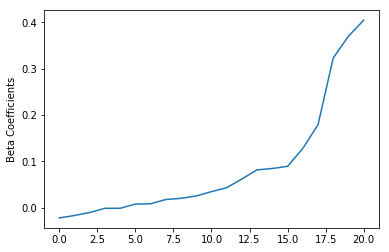

Param(parent='LogisticRegression_cf76d9c95d16', name='featuresCol', doc='features column name')

In [14]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
lrModel.featuresCol

In [15]:
pd.DataFrame({'features': numeric_features, 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
3,company,0.404266
2,blog,0.369862
6,hireable,0.322885
20,WatchEvent_count,0.178962
12,IssueCommentEvent_count,0.127973
19,ReleaseEvent_count,0.089440
15,PublicEvent_count,0.084798
4,public_repos_count,0.081871
5,public_gists_count,0.062283
9,DeleteEvent_count,0.043318


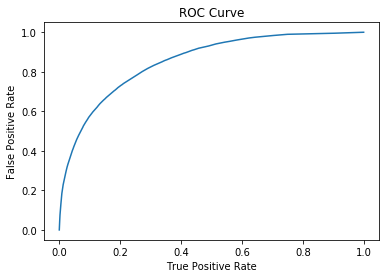

Training set areaUnderROC: 0.8515518833390805


In [16]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

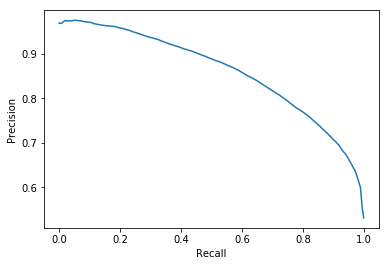

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [18]:
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'company', 'blog', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(150)

+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              5|      1|   1|  0.0|[-0.2875743865139...|       1.0|[0.42859780084065...|
|            323|      1|   1|  0.0|[-6.1241274013450...|       1.0|[0.00218461774929...|
|              2|      1|   1|  0.0|[-14.112890129134...|       1.0|[7.42761476101880...|
|              1|      0|   1|  0.0|[-1.0156892054462...|       1.0|[0.26586794115252...|
|              2|      0|   1|  0.0|[0.52811828753955...|       0.0|[0.62904412558110...|
|              1|      1|   0|  0.0|[-1.6774245634182...|       1.0|[0.15743680038965...|
|              1|      1|   0|  0.0|[0.47172420552578...|       0.0|[0.61579177144164...|
|              1|      0|   0|  0.0|[0.35906587521907...|       0.0|[0.58881428999743...|
|         

## Random forest classification

In [17]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [35]:
h.write_tree_to_file(rfModel.toDebugString, 'rf_trees')

In [18]:
predictions = rfModel.transform(test)
predictions.select(show_cols).show(150)

+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              5|      1|   1|  0.0|[8.96526209783873...|       1.0|[0.44826310489193...|
|            323|      1|   1|  0.0|[5.03278001418684...|       1.0|[0.25163900070934...|
|              2|      1|   1|  0.0|[3.93451986449267...|       1.0|[0.19672599322463...|
|              1|      0|   1|  0.0|[4.78199056058835...|       1.0|[0.23909952802941...|
|              2|      0|   1|  0.0|[10.8046610716962...|       0.0|[0.54023305358481...|
|             10|      1|   0|  0.0|[3.72629687577363...|       1.0|[0.18631484378868...|
|              2|      1|   0|  0.0|[10.5056619154332...|       0.0|[0.52528309577166...|
|              7|      0|   0|  0.0|[4.84299878604326...|       1.0|[0.24214993930216...|
|         

In [19]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(
    predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8526045460138268


In [ ]:
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(train, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(
    lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification tree model:')
print(model.toDebugString())

# Save and load model
model.save(sc, "target/tmp/myDecisionTreeClassificationModel")
sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeClassificationModel")


# Compute raw scores on the test set
predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

## Gradient Boost Tree Classifier

In [20]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)

In [ ]:
h.write_tree_to_file(gbtModel.toDebugString, 'rf_trees')

In [21]:
predictions = gbtModel.transform(test)
predictions.select(show_cols).show(150)

+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              5|      1|   1|  0.0|[-0.1918052014867...|       1.0|[0.40525640774073...|
|            323|      1|   1|  0.0|[-0.3078161870138...|       1.0|[0.35077545034572...|
|              2|      1|   1|  0.0|[-1.1867326528397...|       1.0|[0.08521860811378...|
|              1|      0|   1|  0.0|[-0.7011516408096...|       1.0|[0.19745086980872...|
|              2|      0|   1|  0.0|[0.23834207836890...|       0.0|[0.61696458156200...|
|             10|      1|   0|  0.0|[-1.1522087466428...|       1.0|[0.09075776634646...|
|              2|      1|   0|  0.0|[0.39277848513168...|       0.0|[0.68687653069428...|
|              7|      0|   0|  0.0|[-0.5508946786682...|       1.0|[0.24940477289468...|
|         

In [22]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.860318519301536


## Grid search with cross validation

In [208]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

KeyboardInterrupt: 